# Jansen–Rit Single-Node Simulation

We simulate a single Jansen–Rit (JR) neural mass model node under a variety of inputs to illustrate different regimes: baseline alpha-like rhythms, sinusoidal entrainment, spike–wave-like activity, reduced inhibition, and irregular/noisy dynamics.

The JR model captures mesoscopic cortical column activity using three interacting subpopulations:
- Excitatory pyramidal cells (P) — principal output population;
- Excitatory interneurons (E) — provide excitatory feedback to P;
- Inhibitory interneurons (I) — provide inhibitory feedback to P.

Each subpopulation transforms incoming pulse-density (in Hz) through a synaptic impulse response (with gains and time constants) into membrane potentials (in mV), and a sigmoid nonlinearity maps potentials back to pulse-density. The model’s macroscopic EEG-like output is typically taken as a scaled difference between excitatory and inhibitory postsynaptic potentials onto pyramidal cells.


## Background / Theory

### The Jansen-Rit Model

The **Jansen-Rit model** (1995) describes the dynamics of a cortical column with three interacting neural populations:

1. **Pyramidal cells (M)**: Principal output neurons
2. **Excitatory interneurons (E)**: Provide excitatory feedback to pyramidal cells
3. **Inhibitory interneurons (I)**: Provide inhibitory feedback to pyramidal cells

### Circuit Architecture

```
External Input (p)
      |
      v
  [E: Excitatory] ---(C2)--> [M: Pyramidal] <---(C4)--- [I: Inhibitory]
      ^                           |                          ^
      |                           |                          |
      +---------(C1)--------------+-----------(C3)-----------+
```

### The Equations

Each population has two state variables: membrane potential and its derivative.

$$
\begin{aligned}
\dot{M} &= M_v \\
\dot{E} &= E_v \\
\dot{I} &= I_v \\
\dot{M}_v &= A_e b_e \cdot S(E - I + M_{inp}) - 2 b_e M_v - b_e^2 M \\
\dot{E}_v &= A_e b_e (E_{inp} + C a_2 \cdot S(C a_1 M)) - 2 b_e E_v - b_e^2 E \\
\dot{I}_v &= A_i b_i \cdot C a_4 \cdot S(C a_3 M + I_{inp}) - 2 b_i I_v - b_i^2 I
\end{aligned}
$$

### The Sigmoid Function

Maps membrane potential to firing rate:

$$
S(v) = \frac{s_{max}}{1 + e^{r(v_0 - v)}}
$$

| Parameter | Description | Default |
|-----------|-------------|----------|
| $s_{max}$ | Maximum firing rate | 5 Hz |
| $v_0$ | Half-activation threshold | 6 mV |
| $r$ | Sigmoid steepness | 0.56 |

### EEG Proxy

The EEG-like signal is the difference between excitatory and inhibitory postsynaptic potentials:

$$
EEG(t) = E(t) - I(t)
$$

### Key Parameters

| Parameter | Description | Default | Effect |
|-----------|-------------|---------|--------|
| $A_e$ | Excitatory gain | 3.25 mV | Amplitude of excitatory response |
| $A_i$ | Inhibitory gain | 22 mV | Amplitude of inhibitory response |
| $b_e$ | Excitatory rate | 100 Hz | Speed of excitatory dynamics |
| $b_i$ | Inhibitory rate | 50 Hz | Speed of inhibitory dynamics |
| $C$ | Connectivity constant | 135 | Overall coupling strength |

## Setup
- Import `brainmass` (JR implementation), `brainstate` (simulation/runtime control), `brainunit` for units, and plotting utilities.
- Set the global integration step `dt` to 0.5 ms.
- Define a small helper to plot the pyramidal (M), excitatory (E), inhibitory (I) membrane potentials and the EEG-like output.

In [1]:
import brainmass
import brainstate
import braintools
import brainunit as u
import matplotlib.pyplot as plt
import numpy as np

# Set simulation time step
brainstate.environ.set(dt=0.5 * u.ms)


def show(times, data, title):
    M, E, I, eeg = data
    fig, gs = braintools.visualize.get_figure(4, 1, 1.2, 10)
    fig.add_subplot(gs[0, 0])
    plt.plot(times, M, 'b-', linewidth=0.5)
    plt.ylabel('M (mV)')

    fig.add_subplot(gs[1])
    plt.plot(times, E, 'g-', linewidth=0.5)
    plt.ylabel('E (mV)')

    fig.add_subplot(gs[2])
    plt.plot(times, I, 'r-', linewidth=0.5)
    plt.ylabel('I (mV)')

    fig.add_subplot(gs[3])
    plt.plot(times, eeg, 'k-', linewidth=0.5)
    plt.xlabel('Time (ms)')
    plt.ylabel('EEG (mV)')

    plt.suptitle(title)
    plt.show()

In [2]:
from scipy import signal


def spectral_analysis(eeg):
    dt = brainstate.environ.get_dt()

    # Compute power spectrum
    fs = 1000 / float(dt / u.ms)  # Sampling frequency in Hz
    eeg_signal = np.array(u.get_magnitude(eeg[1000:, 0]))  # Discard transient, ensure numpy array
    f, Pxx = signal.welch(eeg_signal, fs=fs, nperseg=2048)

    fig, axes = plt.subplots(1, 2, figsize=(12, 4))

    # Power spectrum
    axes[0].semilogy(f, Pxx)
    axes[0].set_xlabel('Frequency (Hz)')
    axes[0].set_ylabel('Power Spectral Density')
    axes[0].set_title('EEG Power Spectrum')
    axes[0].set_xlim([0, 50])
    axes[0].axvspan(8, 12, alpha=0.3, color='green', label='Alpha band (8-12 Hz)')
    axes[0].legend()

    # Peak frequency
    peak_idx = np.argmax(Pxx[(f > 5) & (f < 30)]) + np.searchsorted(f, 5)
    peak_freq = f[peak_idx]
    axes[0].axvline(peak_freq, color='r', linestyle='--', label=f'Peak: {peak_freq:.1f} Hz')

    # Time-frequency spectrogram
    f_spec, t_spec, Sxx = signal.spectrogram(eeg_signal, fs=fs, nperseg=512, noverlap=256)
    axes[1].pcolormesh(t_spec * 1000, f_spec, 10 * np.log10(Sxx + 1e-10), shading='gouraud', cmap='viridis')
    axes[1].set_ylabel('Frequency (Hz)')
    axes[1].set_xlabel('Time (ms)')
    axes[1].set_title('Spectrogram')
    axes[1].set_ylim([0, 50])

    plt.tight_layout()
    plt.show()

## Notes on inputs and noise
- Inputs to the JR node (`E_inp`) are specified in Hz, representing background afferent pulse density.
- We generate Gaussian white-noise-like inputs using `brainstate.random.normal(mean, std_per_step, shape) * u.Hz`.
- To maintain step-size–independent noise intensity, the standard deviation scales as `std / sqrt(dt)` where `dt` is in seconds. This follows the usual discretization of a white noise process.

We retrieve `dt` from `brainstate.environ.get_dt()` when constructing input arrays and time axes.

## 1) Alpha-like baseline oscillation
A single JR node with default parameters and moderate noisy drive exhibits an alpha-like rhythm (8–12 Hz).
- Model: `brainmass.JansenRitModel(1)` builds one node (one cortical column).
- Initialization: `node.init_all_states()` sets internal states consistently.
- Drive: mean 120 Hz with noise SD ≈ 30 Hz per sqrt(second), scaled per time step.
- Duration: 10 seconds.

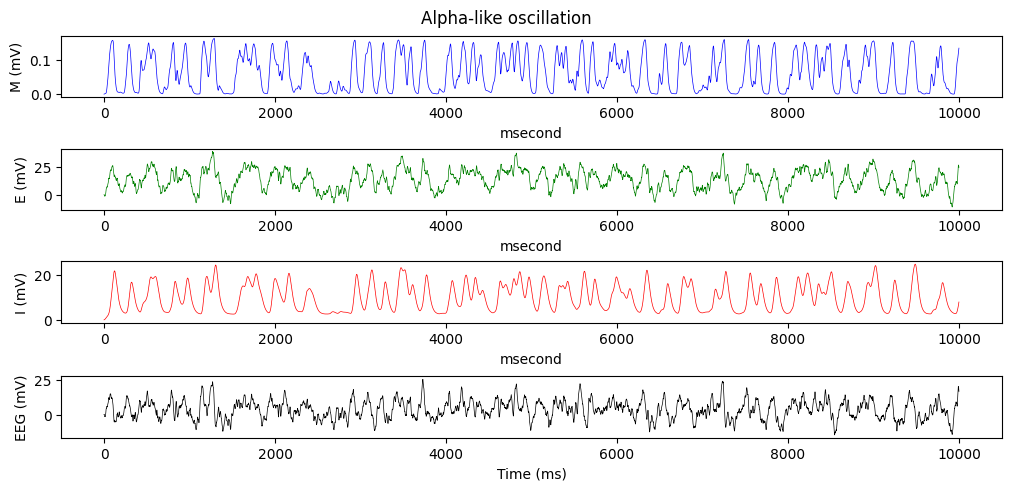

In [3]:
# Alpha-like idle rhythm (baseline JR)
node = brainmass.JansenRitStep(1)
node.init_all_states()


def step_run(inp):
    eeg = node.update(E_inp=inp)
    return node.M.value, node.E.value, node.I.value, eeg


dt = brainstate.environ.get_dt()
indices = np.arange(int(10 * u.second / dt))
inputs = brainstate.random.normal(120., 30. / (dt / u.second) ** 0.5, indices.shape) * u.Hz
data = brainstate.transform.for_loop(step_run, inputs)
show(indices * dt, data, title='Alpha-like oscillation')

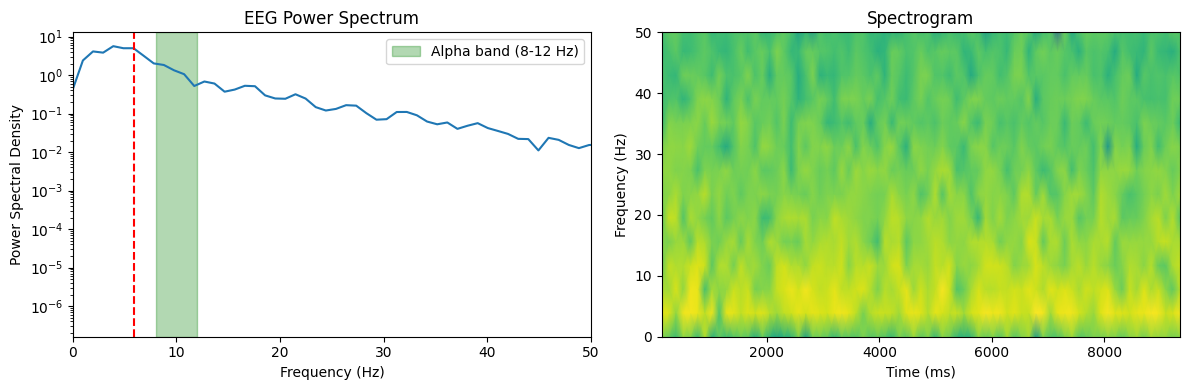

In [4]:
spectral_analysis(data[-1])

## 2) Sinusoidally driven/entrained oscillation
Adding a sinusoidal component to the input can entrain the JR node. Here we drive with a 10 Hz sinusoid around a baseline of ~80 Hz.
- Drive: `inp(t) = 80 + 70 sin(2π f t)` Hz with `f = 10 Hz`.
- Duration: 5 seconds.

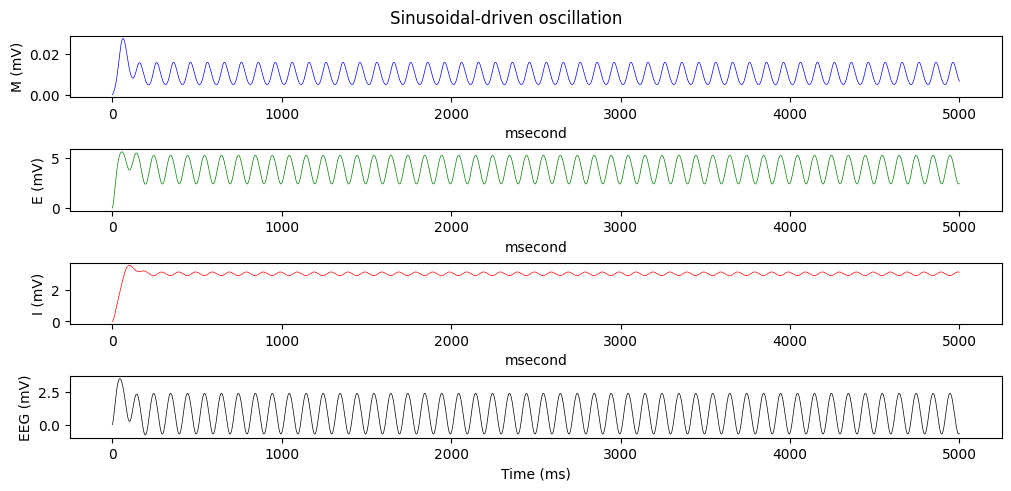

In [5]:
node = brainmass.JansenRitStep(1)
node.init_all_states()
f_drive = 10. * u.Hz


def step_run(i):
    tt = i * dt
    inp = 80 + 70.0 * u.math.sin(2 * u.math.pi * f_drive * tt)
    eeg = node.update(E_inp=inp * u.Hz)
    return node.M.value, node.E.value, node.I.value, eeg


dt = brainstate.environ.get_dt()
indices = np.arange(int(5. * u.second / dt))
data = brainstate.transform.for_loop(step_run, indices)
show(indices * dt, data, title='Sinusoidal-driven oscillation')


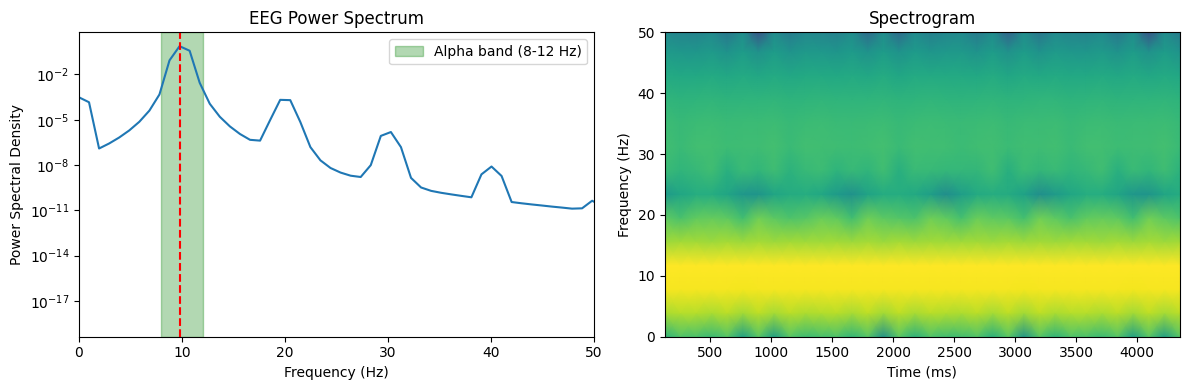

In [6]:
spectral_analysis(data[-1])

## 3) Spike–wave-like regime
Changing synaptic gains and time constants can push the node into a spike–wave-like regime reminiscent of epileptiform dynamics.
- Gains: increase excitatory gain `Ae` and reduce inhibitory gain `Ai` relative to typical JR defaults.
- Time constants: set inhibitory inverse time constant `bi` to 40 Hz (slower than the usual 50–100 Hz range), favoring prolonged inhibitory kinetics.
- Drive: mean 90 Hz with moderate noise.
- Duration: 10 seconds.

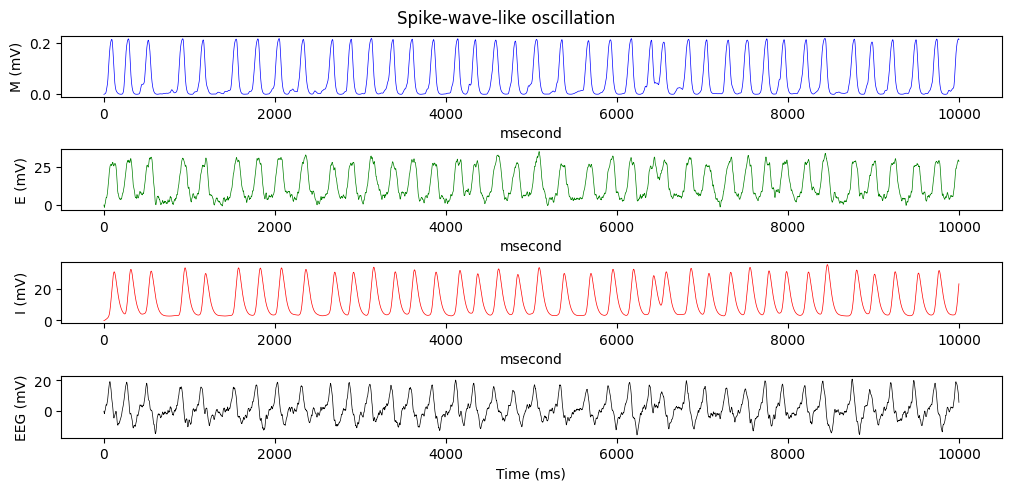

In [7]:
node = brainmass.JansenRitStep(1, Ae=4.5 * u.mV, Ai=18. * u.mV, bi=40. * u.Hz)
node.init_all_states()


def step_run(inp):
    eeg = node.update(E_inp=inp)
    return node.M.value, node.E.value, node.I.value, eeg


dt = brainstate.environ.get_dt()
indices = np.arange(int(10 * u.second / dt))
inputs = brainstate.random.normal(90., 10. / (dt / u.second) ** 0.5, indices.shape) * u.Hz
data = brainstate.transform.for_loop(step_run, inputs)
show(indices * dt, data, title='Spike-wave-like oscillation')


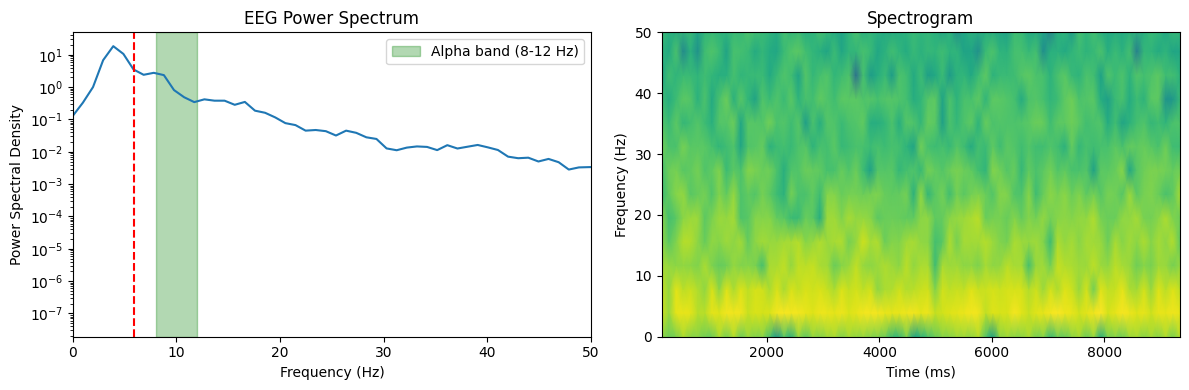

In [8]:
spectral_analysis(data[-1])

## 4) Reduced inhibition (disinhibited)
Lowering inhibitory strength typically increases oscillation amplitude and can shift frequency.
- Parameters: lower `Ai` and use `bi = 40 Hz`.
- Drive: mean 100 Hz with noise SD ≈ 20 Hz per sqrt(second).
- Duration: 10 seconds.

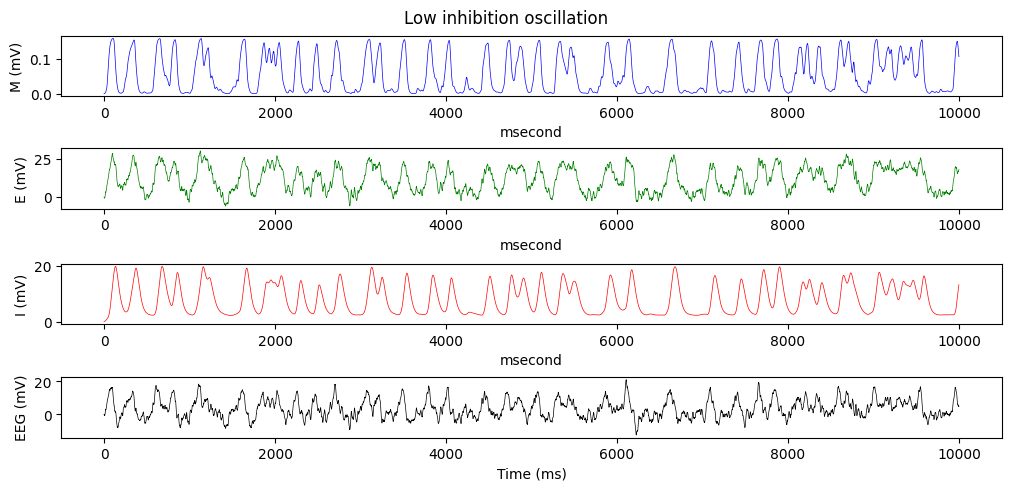

In [9]:
node = brainmass.JansenRitStep(1, Ai=15. * u.mV, bi=40. * u.Hz)
node.init_all_states()


def step_run(inp):
    eeg = node.update(E_inp=inp)
    return node.M.value, node.E.value, node.I.value, eeg


dt = brainstate.environ.get_dt()
indices = np.arange(int(10 * u.second / dt))
inputs = brainstate.random.normal(100., 20. / (dt / u.second) ** 0.5, indices.shape) * u.Hz
data = brainstate.transform.for_loop(step_run, inputs)
show(indices * dt, data, title='Low inhibition oscillation')


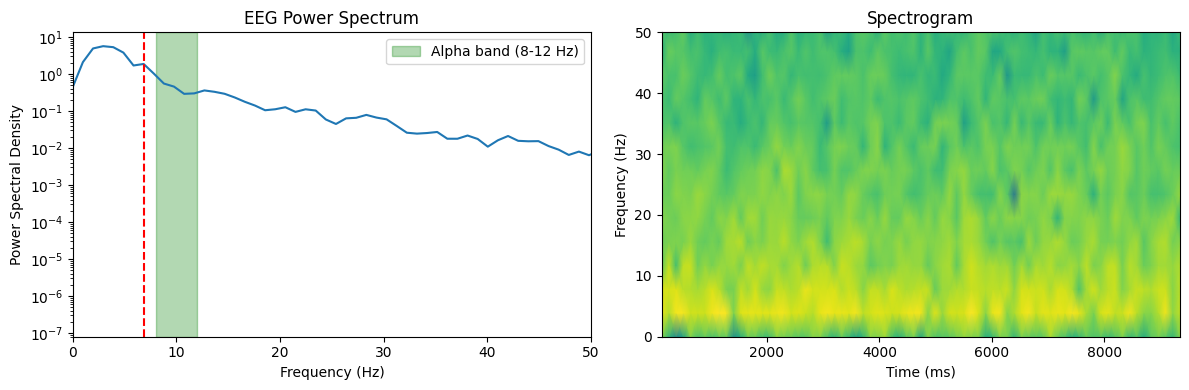

In [10]:
spectral_analysis(data[-1])

## 5) Irregular/noisy regime
Increasing mean drive and noise level yields more irregular, broadband dynamics.
- Drive: mean 220 Hz with high noise SD ≈ 80 Hz per sqrt(second).
- Duration: 10 seconds.

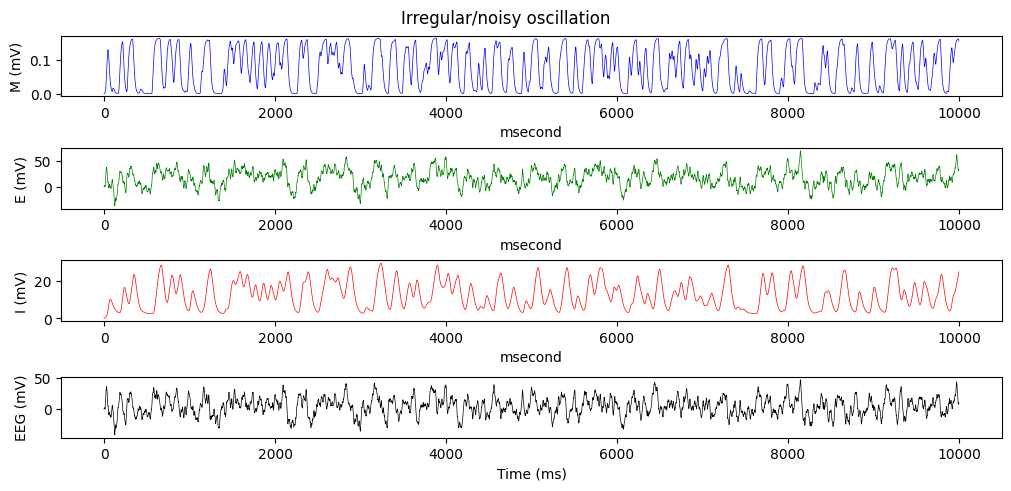

In [11]:
node = brainmass.JansenRitStep(1)
node.init_all_states()


def step_run(inp):
    eeg = node.update(E_inp=inp)
    return node.M.value, node.E.value, node.I.value, eeg


dt = brainstate.environ.get_dt()
indices = np.arange(int(10 * u.second / dt))
inputs = brainstate.random.normal(220., 80. / (dt / u.second) ** 0.5, indices.shape) * u.Hz
data = brainstate.transform.for_loop(step_run, inputs)
show(indices * dt, data, title='Irregular/noisy oscillation')


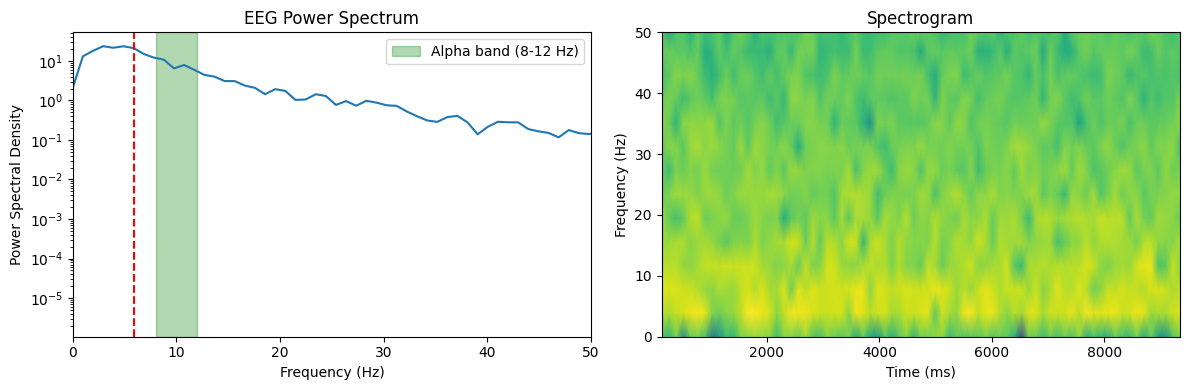

In [12]:
spectral_analysis(data[-1])

## 6) Input-Driven Bifurcation

Sweep external input to reveal different dynamical regimes:

In [ ]:
# Input values to sweep
E_inp_values = np.linspace(50, 300, 50) * u.Hz

node = brainmass.JansenRitStep(len(E_inp_values))
node.init_all_states()


def step(i):
    return node.update(E_inp=E_inp_values)


dt = brainstate.environ.get_dt()
indices = np.arange(int(3 * u.second / dt))
eeg = brainstate.transform.for_loop(step, indices)

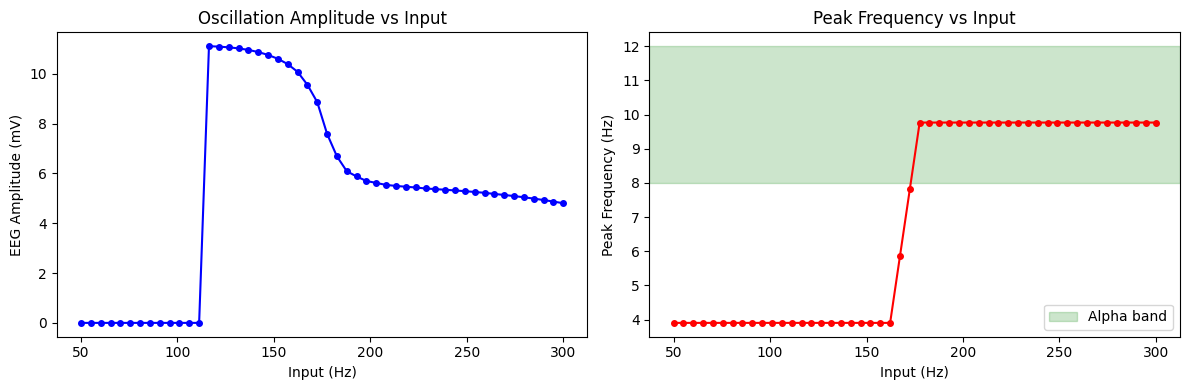

In [15]:
fs = 1000 / float(dt / u.ms)
peak_freqs = []
amplitudes = []
for i in range(len(E_inp_values)):
    # Analyze steady-state
    eeg_ss = np.array(u.get_magnitude(eeg[2000:, i]))
    amplitudes.append(eeg_ss.max() - eeg_ss.min())

    # Peak frequency
    f, Pxx = signal.welch(eeg_ss, fs=fs, nperseg=1024)
    peak_idx = np.argmax(Pxx[(f > 3) & (f < 40)])
    peak_freqs.append(f[(f > 3) & (f < 40)][peak_idx])

# Plot results
fig, axes = plt.subplots(1, 2, figsize=(12, 4))

axes[0].plot(E_inp_values / u.Hz, amplitudes, 'b-o', markersize=4)
axes[0].set_xlabel('Input (Hz)')
axes[0].set_ylabel('EEG Amplitude (mV)')
axes[0].set_title('Oscillation Amplitude vs Input')

axes[1].plot(E_inp_values / u.Hz, peak_freqs, 'r-o', markersize=4)
axes[1].set_xlabel('Input (Hz)')
axes[1].set_ylabel('Peak Frequency (Hz)')
axes[1].set_title('Peak Frequency vs Input')
axes[1].axhspan(8, 12, alpha=0.2, color='green', label='Alpha band')
axes[1].legend()

plt.tight_layout()
plt.show()

## 7) E/I Gain Parameter Space

Explore how excitatory and inhibitory gains affect dynamics:

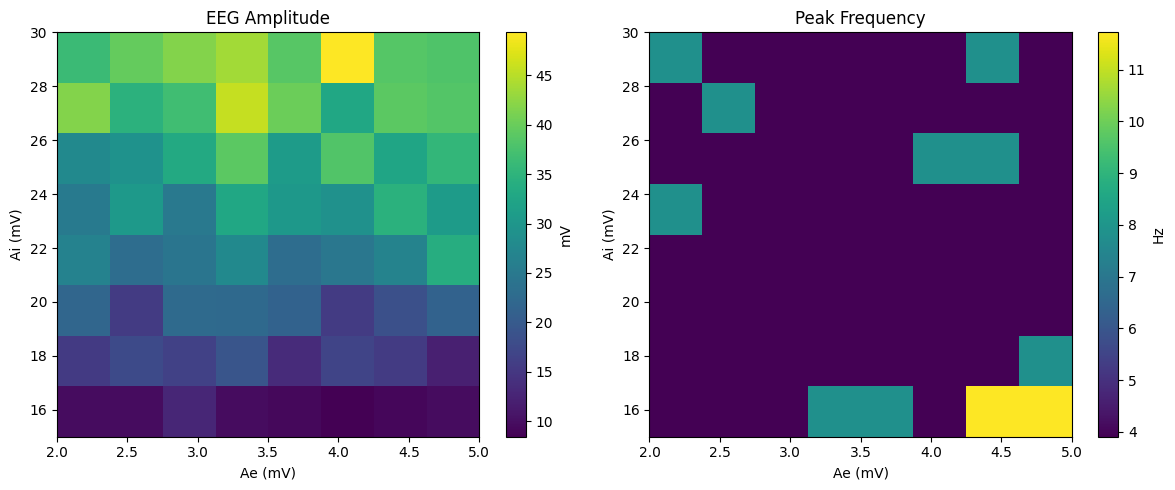

In [24]:
@brainstate.transform.vmap2
def single_trial(Ae, Ai):
    node = brainmass.JansenRitStep(1, Ae=Ae, Ai=Ai)
    node.init_all_states()

    def step(inp):
        return node.update(E_inp=inp)

    indices = np.arange(int(2 * u.second / dt))
    noise_std = 20. / (float(dt / u.second) ** 0.5)
    inputs = brainstate.random.normal(120., noise_std, indices.shape) * u.Hz
    eeg = brainstate.transform.for_loop(step, inputs)
    return eeg


@brainstate.transform.jit
def multi_trials(Aes, Ais):
    eegs = single_trial(Aes.flatten(), Ais.flatten())
    return u.math.reshape(eegs, (*Aes.shape, -1))


# Parameter grid
Ae_values = np.linspace(2.0, 5.0, 8) * u.mV
Ai_values = np.linspace(15., 30., 8) * u.mV

all_eegs = multi_trials(*u.math.meshgrid(Ae_values, Ai_values, indexing='ij'))

amplitude_grid = np.zeros((len(Ai_values), len(Ae_values)))
freq_grid = np.zeros((len(Ai_values), len(Ae_values)))

fs = 1000 / float(dt / u.ms)
for i, Ai in enumerate(Ai_values):
    for j, Ae in enumerate(Ae_values):
        eeg_ss = np.array(u.get_magnitude(all_eegs[i, j, 1000:]))
        amplitude_grid[i, j] = eeg_ss.max() - eeg_ss.min()

        f, Pxx = signal.welch(eeg_ss, fs=fs, nperseg=512)
        peak_idx = np.argmax(Pxx[(f > 3) & (f < 40)])
        freq_grid[i, j] = f[(f > 3) & (f < 40)][peak_idx]

# Plot
fig, axes = plt.subplots(1, 2, figsize=(12, 5))

im1 = axes[0].imshow(amplitude_grid, aspect='auto', origin='lower',
                     extent=[float(Ae_values[0] / u.mV), float(Ae_values[-1] / u.mV),
                             float(Ai_values[0] / u.mV), float(Ai_values[-1] / u.mV)])
axes[0].set_xlabel('Ae (mV)')
axes[0].set_ylabel('Ai (mV)')
axes[0].set_title('EEG Amplitude')
plt.colorbar(im1, ax=axes[0], label='mV')

im2 = axes[1].imshow(freq_grid, aspect='auto', origin='lower', cmap='viridis',
                     extent=[float(Ae_values[0] / u.mV), float(Ae_values[-1] / u.mV),
                             float(Ai_values[0] / u.mV), float(Ai_values[-1] / u.mV)])
axes[1].set_xlabel('Ae (mV)')
axes[1].set_ylabel('Ai (mV)')
axes[1].set_title('Peak Frequency')
plt.colorbar(im2, ax=axes[1], label='Hz')

plt.tight_layout()
plt.show()

## Key Insights

| Regime | Parameters | EEG Character |
|--------|------------|---------------|
| Alpha | Default | 8-12 Hz, regular |
| Spike-wave | High Ae, low Ai, slow bi | Sharp spikes + slow waves |
| Disinhibited | Low Ai | High amplitude |
| Irregular | High input + noise | Broadband |

## Clinical Relevance

The Jansen-Rit model has been used to study:
- Alpha rhythm generation in visual cortex
- Epileptic spike-wave discharges
- Evoked potentials (ERP, VEP)
- Pathological oscillations


## References

1. Jansen, B. H., & Rit, V. G. (1995). Electroencephalogram and visual evoked potential generation in a mathematical model of coupled cortical columns. *Biological Cybernetics*, 73(4), 357-366.

2. David, O., & Friston, K. J. (2003). A neural mass model for MEG/EEG: coupling and neuronal dynamics. *NeuroImage*, 20(3), 1743-1755.

3. Wendling, F., Bartolomei, F., Bellanger, J. J., & Chauvel, P. (2002). Epileptic fast activity can be explained by a model of impaired GABAergic dendritic inhibition. *European Journal of Neuroscience*, 15(9), 1499-1508.

4. Grimbert, F., & Faugeras, O. (2006). Bifurcation analysis of Jansen's neural mass model. *Neural Computation*, 18(12), 3052-3068.